# Transfer Learning - Scaling Up

In [2]:
# Importing TF and checking the version
import tensorflow as tf

print(tf.__version__)

2.10.1


In [3]:
# Importing custom helper functions
from DanielBourke_HelperFunctions import create_tensorboard_callback, plot_loss_curves, compare_historys, walk_through_dir

In [4]:
# Setting data directories
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [5]:
# How many images are we dealing with
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent\test'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bread_pudding'.
There are 0 directories and 250 images in '10

In [6]:
# Setting up data inputs
IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    image_size=IMG_SIZE
)

test_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    shuffle=False # Don't shuffle test data
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [7]:
# Creating checkpoint callback
checkpoint_path = "101_food_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)

In [8]:
# Creating data augmentation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
    # preprocessing.Rescaling(1./255) - for models, that don't auto-rescale
], name="data_augmentation")

In [9]:
# Setting up the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setting up layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(
    len(train_data_all_10_percent.class_names),
    activation="softmax",
    name="output_layer"
)(x)
model = tf.keras.Model(inputs, outputs)

In [10]:
# Getting the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [11]:
# Compiling the model
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Fitting the model
history = model.fit(
    train_data_all_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_all_10_percent),
    validation_data=test_data_all_10_percent,
    validation_steps=int(0.25 * len(test_data_all_10_percent)),
    callbacks=[checkpoint_callback]
)

Epoch 1/5
237/237 [==============================] - 1151s 5s/step - loss: 3.3742 - accuracy: 0.2739 - val_loss: 2.5403 - val_accuracy: 0.4067
Epoch 2/5
237/237 [==============================] - 887s 4s/step - loss: 2.2028 - accuracy: 0.4974 - val_loss: 2.0600 - val_accuracy: 0.4932
Epoch 3/5
237/237 [==============================] - 982s 4s/step - loss: 1.8261 - accuracy: 0.5629 - val_loss: 1.8742 - val_accuracy: 0.5217
Epoch 4/5
237/237 [==============================] - 1164s 5s/step - loss: 1.6094 - accuracy: 0.6114 - val_loss: 1.8499 - val_accuracy: 0.5198
Epoch 5/5
237/237 [==============================] - 1030s 4s/step - loss: 1.4485 - accuracy: 0.6411 - val_loss: 1.7757 - val_accuracy: 0.5365


In [12]:
# Evaluating on the whole dataset
feature_extraction_results = model.evaluate(test_data_all_10_percent)
feature_extraction_results

790/790 [==============================] - 1089s 1s/step - loss: 1.5872 - accuracy: 0.5837


[1.587180733680725, 0.58368319272995]

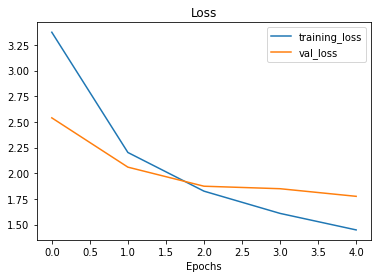

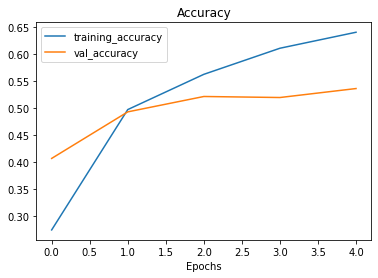

In [13]:
# Visualising the loss curves
plot_loss_curves(history=history)

### Fine-Tuning

In [14]:
# Unfreeze all layers
base_model.trainable = True

# Refreeze all layers except for the last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [15]:
# Recompiling the model with a lower learning rate
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

In [16]:
# Checking which layers are trainable
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling_layer True
output_layer True


In [17]:
# Checking which layers are trainable in the base model
for layer_number, layer in enumerate(model.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [18]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10

history_finetuned = model.fit(
    train_data_all_10_percent,
    epochs=fine_tune_epochs,
    steps_per_epoch=len(train_data_all_10_percent),
    validation_data=test_data_all_10_percent,
    validation_steps=int(0.15 * len(test_data_all_10_percent)),
    initial_epoch=history.epoch[-1]
)

Epoch 5/10
237/237 [==============================] - 434s 2s/step - loss: 1.2107 - accuracy: 0.6805 - val_loss: 1.7598 - val_accuracy: 0.5400
Epoch 6/10
237/237 [==============================] - 409s 2s/step - loss: 1.0997 - accuracy: 0.7100 - val_loss: 1.7156 - val_accuracy: 0.5493
Epoch 7/10
237/237 [==============================] - 398s 2s/step - loss: 0.9948 - accuracy: 0.7332 - val_loss: 1.6968 - val_accuracy: 0.5559
Epoch 8/10
237/237 [==============================] - 417s 2s/step - loss: 0.9543 - accuracy: 0.7422 - val_loss: 1.7138 - val_accuracy: 0.5506
Epoch 9/10
237/237 [==============================] - 996s 4s/step - loss: 0.8767 - accuracy: 0.7612 - val_loss: 1.7232 - val_accuracy: 0.5487
Epoch 10/10
237/237 [==============================] - 376s 2s/step - loss: 0.8333 - accuracy: 0.7766 - val_loss: 1.7028 - val_accuracy: 0.5564


In [19]:
# Evaluating on the whole test dataset
fine_tuning_results = model.evaluate(test_data_all_10_percent)
fine_tuning_results

790/790 [==============================] - 823s 1s/step - loss: 1.4947 - accuracy: 0.6056


[1.4947346448898315, 0.6056237816810608]

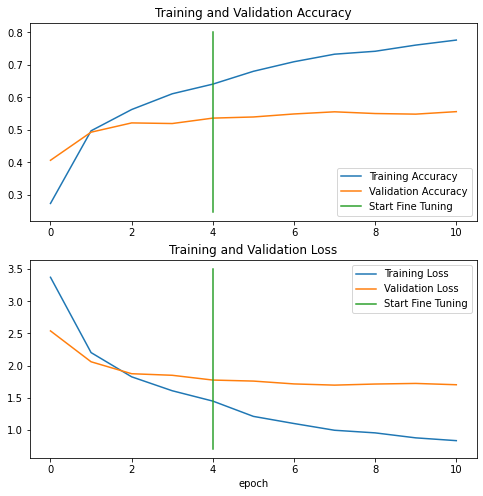

In [20]:
# Comparing histories
compare_historys(
    original_history=history,
    new_history=history_finetuned,
    initial_epochs=5
)

In [21]:
# Saving fine-tuned model
tf.keras.models.save_model(model=model, filepath="saved_model/finetuned_10p")
#model.save("saved_model/finetuned_10p")

INFO:tensorflow:Assets written to: saved_model/finetuned_10p\assets


INFO:tensorflow:Assets written to: saved_model/finetuned_10p\assets


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [ ]:
# Loading saved model
loaded_model = tf.keras.models.load_model("saved_model/finetuned_10p")

### Making predictions

In [22]:
# Checking model prediction probabilities
preds_probs = model.predict(test_data_all_10_percent, verbose=1)

790/790 [==============================] - 1491s 2s/step


In [23]:
# Shape of predictions
preds_probs.shape

(25250, 101)

In [24]:
# First 10 predictions
preds_probs[:10]

array([[1.8826354e-01, 1.1564081e-03, 1.6168696e-01, ..., 1.4657000e-05,
        6.9652200e-03, 3.1218598e-02],
       [9.7026968e-01, 3.5232592e-08, 3.4898423e-04, ..., 5.6087086e-04,
        8.2984307e-08, 1.4382700e-06],
       [5.4348797e-01, 1.1399380e-02, 2.6976544e-02, ..., 1.3662764e-04,
        5.2475766e-04, 2.0190764e-03],
       ...,
       [5.3867966e-01, 1.8715262e-05, 2.2716317e-03, ..., 8.1987962e-02,
        1.0759012e-03, 7.1868519e-05],
       [3.9754111e-01, 2.7858923e-04, 1.7772177e-01, ..., 2.6151750e-04,
        3.1453022e-04, 2.9111435e-04],
       [7.7205282e-01, 1.0644171e-06, 1.2412457e-03, ..., 1.6963963e-03,
        2.6141106e-06, 1.6058324e-03]], dtype=float32)

In [25]:
# Getting predictions per class
print(f"Number of prediction probabiliyies: {len(preds_probs[0])}")
print(f"What prediction 0 looks like:\n {preds_probs[0]}")
print(f"What is the highest probability {preds_probs[0].argmax()}")

Number of prediction probabiliyies: 101
What prediction 0 looks like:
 [1.88263535e-01 1.15640811e-03 1.61686957e-01 7.58197345e-08
 1.72851207e-06 9.70521342e-07 5.97968210e-05 5.75645072e-06
 2.29795389e-02 7.18104769e-04 6.56926829e-07 5.49062270e-06
 3.87211563e-04 3.47597307e-07 7.38492562e-03 1.92600652e-03
 6.28857379e-06 4.61792108e-04 4.56690509e-03 6.16217994e-06
 1.18864281e-03 9.38074754e-06 6.95365743e-05 5.80966298e-05
 3.97566881e-04 3.63567937e-03 2.70023505e-04 1.60045875e-05
 1.54936180e-01 1.24437152e-03 7.86766941e-06 5.64561982e-04
 3.78666940e-04 3.01005798e-07 8.25891737e-03 8.30503541e-06
 2.73208250e-04 2.60125077e-03 3.11460085e-02 5.46967858e-05
 1.16336851e-04 1.76216522e-03 1.93090120e-04 5.02093235e-06
 3.17274913e-04 2.04454791e-05 3.23553407e-03 7.79890543e-05
 3.36506616e-07 1.03910372e-01 2.02319861e-04 1.41565397e-04
 8.04816186e-02 2.05901619e-02 1.36276813e-05 2.49913754e-03
 3.31396125e-02 7.22558994e-04 4.52414301e-04 6.15639074e-05
 3.46950173e-0

In [26]:
# Getting all predicted classes
pred_classes = preds_probs.argmax(axis=1)

# Checking first 10 predictions
pred_classes[:10]

array([ 0,  0,  0,  8,  8, 78, 29,  0,  0,  0], dtype=int64)

In [27]:
# How many classes we have
len(pred_classes)

25250

In [28]:
# Extracting test labels
y_labels = []

for images, labels in test_data_all_10_percent.unbatch():
    y_labels.append(labels.numpy().argmax())

# Checking the first 10
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [29]:
# Checking accuracy score
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_true=y_labels, y_pred=pred_classes)
sklearn_accuracy

0.6056237623762376

In [30]:
# Checking if accuracy metrics are close
import numpy as np

np.isclose(fine_tuning_results[1], sklearn_accuracy)

True

In [33]:
# Test data class names
class_names = test_data_all_10_percent.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

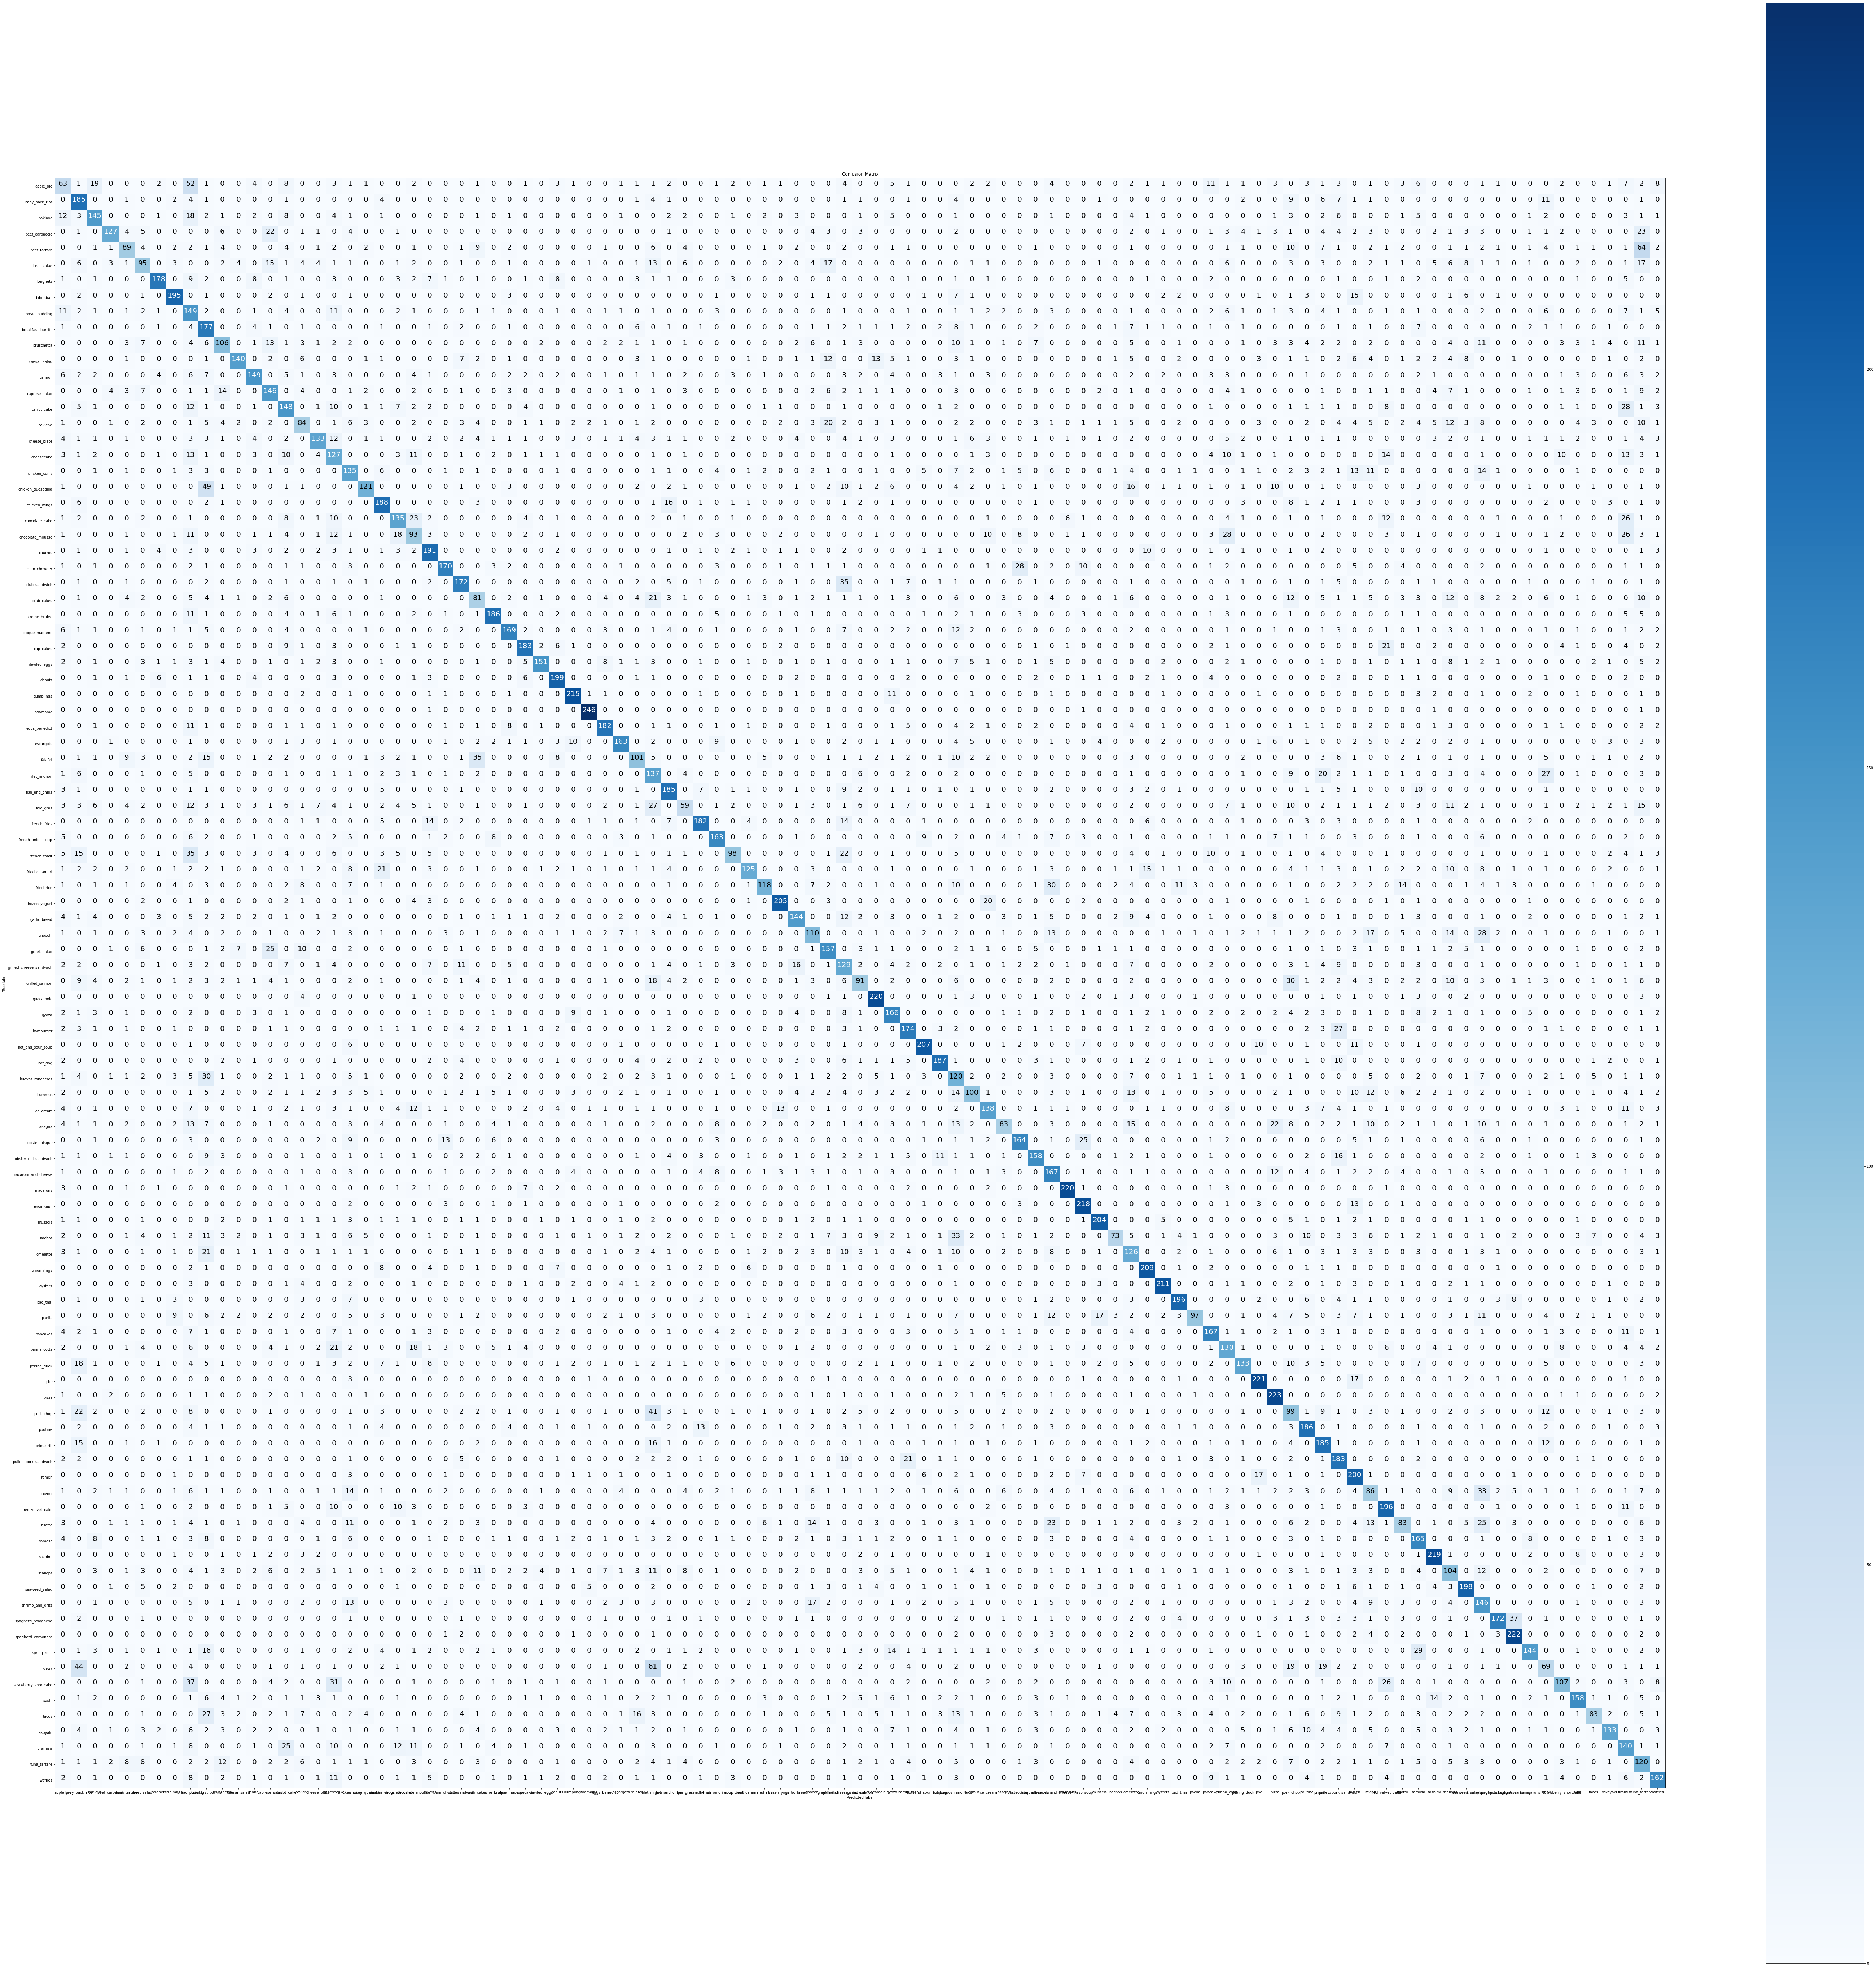

In [32]:
# Visualising confusion matrix
from DanielBourke_HelperFunctions import make_confusion_matrix

make_confusion_matrix(
    y_true=y_labels,
    y_pred=pred_classes,
    classes=class_names,
    figsize=(100, 100),
    text_size=20
)

In [34]:
# SKLearn classification metrics
from sklearn.metrics import classification_report
print(classification_report(
    y_true=y_labels,
    y_pred=pred_classes
))

              precision    recall  f1-score   support

           0       0.33      0.25      0.29       250
           1       0.48      0.74      0.58       250
           2       0.63      0.58      0.60       250
           3       0.86      0.51      0.64       250
           4       0.57      0.36      0.44       250
           5       0.50      0.38      0.43       250
           6       0.84      0.71      0.77       250
           7       0.81      0.78      0.79       250
           8       0.26      0.60      0.36       250
           9       0.37      0.71      0.48       250
          10       0.52      0.42      0.47       250
          11       0.85      0.56      0.67       250
          12       0.71      0.60      0.65       250
          13       0.52      0.58      0.55       250
          14       0.48      0.59      0.53       250
          15       0.45      0.34      0.38       250
          16       0.70      0.53      0.60       250
          17       0.36    